In [1]:
import pysftp
import xarray as xr
import numpy as np
#import cartopy as cy
import matplotlib.pyplot as plt

from datetime import datetime
#from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

import functions as fct
%load_ext autoreload
%autoreload 2

In [2]:
# Set figure size for all our plots
plt.rcParams['figure.figsize'] = [10., 8.]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 22})

In [3]:
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
date = now.strftime("%Y%m%d")
time = now.strftime('%H')
print("date and time =", date, time)	


date and time = 20200214 15


In [4]:
forecast_in_hours = 12

In [5]:
ini_time = '09'

In [6]:
savefig = 1   # 1=yes, 0=no
form = 'png'
fig_name = 'meps_2_5_km_%sT%sZ_%s.%s' %(date,ini_time,forecast_in_hours, form)
#figdir = 'sftp://franzihe@login.uio.no/uio/kant/geo-metos-u1/franzihe/www_docs'
figdir = '/home/franzihe/Documents/Figures/Weathermaps'

In [7]:
# Pick out area around 400km to Andenes
# Andøya Space Center Coordinates: 69.2950N, 16.0300E
andenes_lat = 69.2950; andenes_lon = 16.03
#lower_lat = 65.69; lower_lon = 5.8
#upper_lat = 72.9;  upper_lon = 26.26
lower_lat = 65.; lower_lon = 1.24
upper_lat = 75;  upper_lon = 26.26

In [8]:
#  Open the netCDF file containing the input data.
fnx = xr.open_dataset('https://thredds.met.no/thredds/dodsC/mepslatest/meps_det_2_5km_%sT%sZ.ncml' %(date, ini_time), decode_times  = True, use_cftime = True)

In [9]:
lower_x, lower_y = fct.find_yx(fnx.latitude, fnx.longitude, lower_lat, lower_lon)
upper_x, upper_y = fct.find_yx(fnx.latitude, fnx.longitude, upper_lat, upper_lon)
andenes_x, andenes_y = fct.find_yx(fnx.latitude, fnx.longitude, andenes_lat, andenes_lon)

In [10]:
map_area = 'Andoya'

/home/franzihe/anaconda3/envs/weathermap/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/franzihe/anaconda3/envs/weathermap/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/franzihe/anaconda3/envs/weathermap/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/franzihe/anaconda3/envs/weathermap/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/franzihe/anaco

plot saved: /home/franzihe/Documents/Figures/Weathermaps/700hPa_RH_T/Andoya/meps_2_5_km_20200214T09Z_12.png


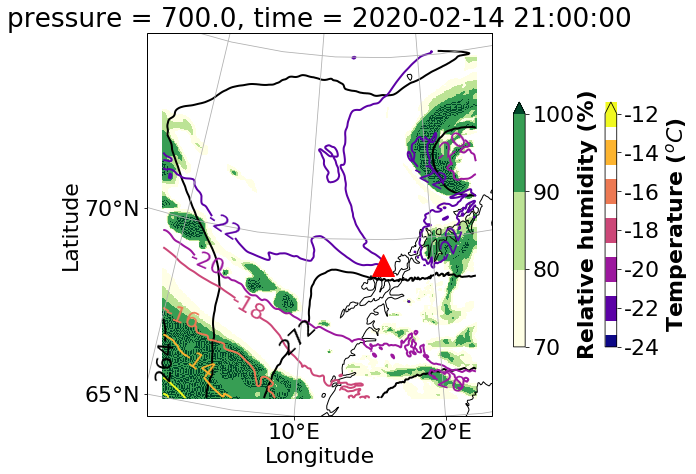

In [11]:
### 700hP - Temp - RH
fct.plt_700_humidity(fnx, fnx.geopotential_pl.sel(pressure = 700.,
                                         x = slice(lower_x, upper_x),
                                         y = slice(lower_y, upper_y)).isel(time=forecast_in_hours)/100, 
                 fnx.air_temperature_pl.sel(pressure = 700.,
                                            x = slice(lower_x, upper_x),
                                            y = slice(lower_y, upper_y)).isel(time = forecast_in_hours) - 273.15, 
                 fnx.relative_humidity_pl.sel(pressure = 700.,
                                              x = slice(lower_x, upper_x),
                                              y = slice(lower_y, upper_y)).isel(time = forecast_in_hours)*100, 
                 andenes_x, andenes_y)

if savefig == 1:
    fct.createFolder('%s/700hPa_RH_T/%s/' %(figdir,map_area))
    plt.savefig('%s/700hPa_RH_T/%s/%s' %(figdir, map_area, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/700hPa_RH_T/%s/%s' %(figdir, map_area, fig_name))
    

/home/franzihe/anaconda3/envs/weathermap/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


plot saved: /home/franzihe/Documents/Figures/Weathermaps/MSLP_Thickness_Jet/Andoya/meps_2_5_km_20200214T09Z_12.png


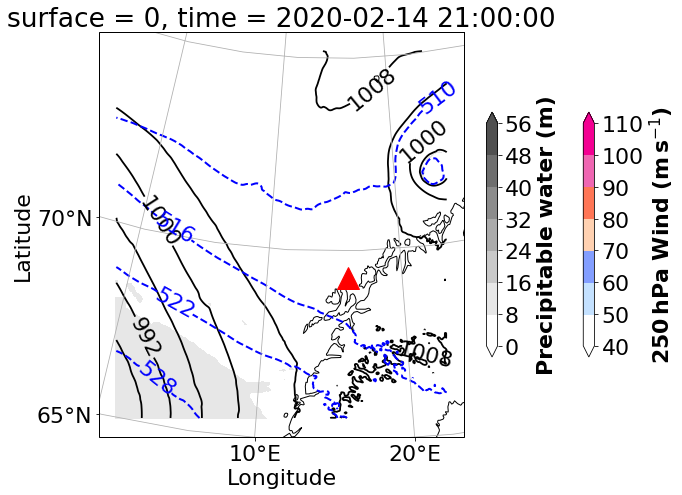

In [12]:
# convert Geopotential to height
# https://en.wikipedia.org/wiki/Geopotential
a = 6.378*10**6     # average radius of the earth  [m]
G = 6.673*10**(-11) # gravitational constant       [Nm2/kg2]
ma = 5.975*10**24   #  mass of the earth           [kg]

Z_1000 = (-a**2 * fnx.geopotential_pl.sel(pressure = 1000.,).isel(time = forecast_in_hours))/\
         (a * fnx.geopotential_pl.sel(pressure = 1000.,).isel(time = forecast_in_hours) - G * ma)

Z_500 = (-a**2 * fnx.geopotential_pl.sel(pressure = 500.,).isel(time = forecast_in_hours))/\
         (a * fnx.geopotential_pl.sel(pressure = 500.,).isel(time = forecast_in_hours) - G * ma)

Z_thickness = (Z_500 - Z_1000)/10

########################################    
### Jet - Thickness - MSLP    
fct.plt_Jet_Thick_MSLP(fnx, np.sqrt(fnx.x_wind_pl.sel(pressure = 250.,x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours)**2 + \
                                    fnx.y_wind_pl.sel(pressure = 250.,x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours)**2),
                   fnx.air_pressure_at_sea_level.sel(height_above_msl = 0, x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours)/100, 
                   Z_thickness.sel(x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)),
                   fnx.lwe_thickness_of_atmosphere_mass_content_of_water_vapor.sel(surface = 0, x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours),
                   andenes_x, andenes_y)
if savefig == 1:
    fct.createFolder('%s/MSLP_Thickness_Jet/%s/' %(figdir,map_area))
    plt.savefig('%s/MSLP_Thickness_Jet/%s/%s' %(figdir, map_area, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/MSLP_Thickness_Jet/%s/%s' %(figdir, map_area, fig_name))

plot saved: /home/franzihe/Documents/Figures/Weathermaps/850hPa_U_T/Andoya/meps_2_5_km_20200214T09Z_12.png


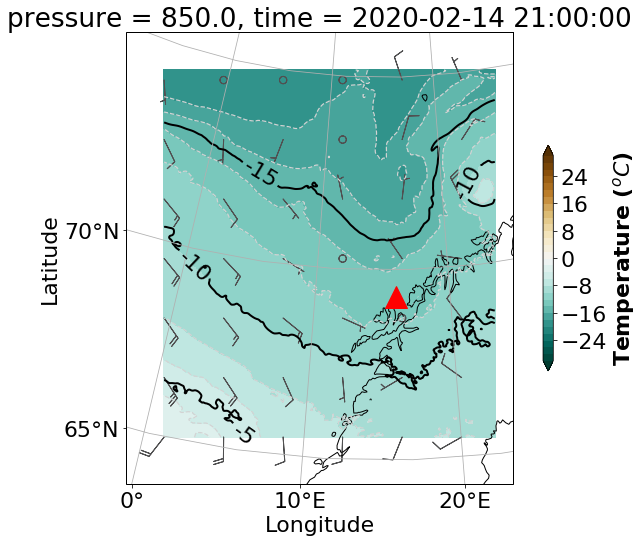

In [13]:
XX, YY = np.meshgrid(fnx.x.sel(x = slice(lower_x, upper_x)), 
                     fnx.y.sel(y = slice(lower_y, upper_y)))
fct.plt_temp_wind_850(fnx, fnx.air_temperature_pl.sel(pressure = 850.,x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours) - 273.15,
                      fnx.x_wind_pl.sel(pressure = 850.,x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours),
                      fnx.y_wind_pl.sel(pressure = 850.,x = slice(lower_x, upper_x),y = slice(lower_y, upper_y)).isel(time = forecast_in_hours),
                      XX, YY,
                      andenes_x, andenes_y)

if savefig == 1:
    fct.createFolder('%s/850hPa_U_T/%s/' %(figdir,map_area))
    plt.savefig('%s/850hPa_U_T/%s/%s' %(figdir, map_area, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/850hPa_U_T/%s/%s' %(figdir, map_area, fig_name))

In [14]:
map_area = 'Norway'

plot saved: /home/franzihe/Documents/Figures/Weathermaps/700hPa_RH_T/Norway/meps_2_5_km_20200214T09Z_12.png


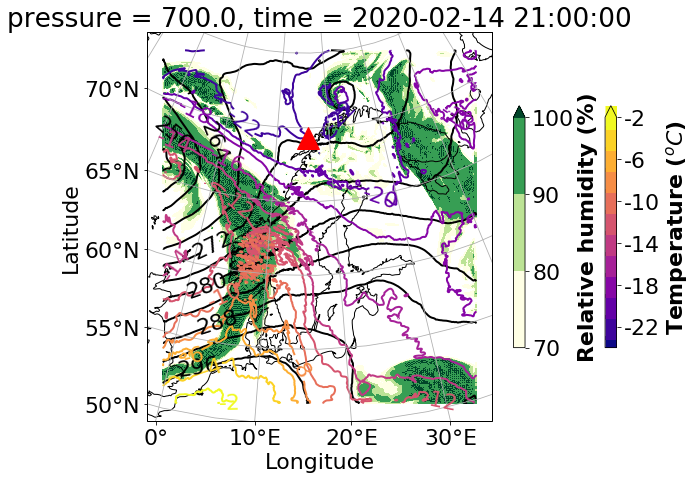

In [17]:
fct.plt_700_humidity(fnx, fnx.geopotential_pl.sel(pressure = 700.,).isel(time=forecast_in_hours)/100, 
                 fnx.air_temperature_pl.sel(pressure = 700.,).isel(time = forecast_in_hours) - 273.15, 
                 fnx.relative_humidity_pl.sel(pressure = 700.,).isel(time = forecast_in_hours)*100, 
                 andenes_x, andenes_y)

if savefig == 1:
    fct.createFolder('%s/700hPa_RH_T/%s/' %(figdir,map_area))
    plt.savefig('%s/700hPa_RH_T/%s/%s' %(figdir, map_area, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/700hPa_RH_T/%s/%s' %(figdir, map_area, fig_name))
    

plot saved: /home/franzihe/Documents/Figures/Weathermaps/MSLP_Thickness_Jet/Norway/meps_2_5_km_20200214T09Z_12.png


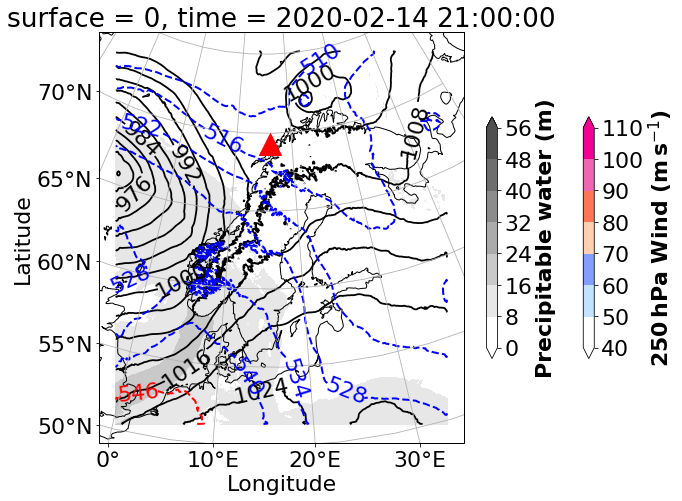

In [19]:
fct.plt_Jet_Thick_MSLP(fnx, np.sqrt(fnx.x_wind_pl.sel(pressure = 250.,).isel(time = forecast_in_hours)**2 + fnx.y_wind_pl.sel(pressure = 250.,).isel(time = forecast_in_hours)**2), 
                   fnx.air_pressure_at_sea_level.sel(height_above_msl = 0).isel(time = forecast_in_hours)/100, 
                   Z_thickness, 
                   fnx.lwe_thickness_of_atmosphere_mass_content_of_water_vapor.sel(surface = 0).isel(time = forecast_in_hours), 
                   andenes_x, andenes_y)

if savefig == 1:
    fct.createFolder('%s/MSLP_Thickness_Jet/%s/' %(figdir,map_area))
    plt.savefig('%s/MSLP_Thickness_Jet/%s/%s' %(figdir, map_area, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/MSLP_Thickness_Jet/%s/%s' %(figdir, map_area, fig_name))

plot saved: /home/franzihe/Documents/Figures/Weathermaps/850hPa_U_T/Norway/meps_2_5_km_20200214T09Z_12.png


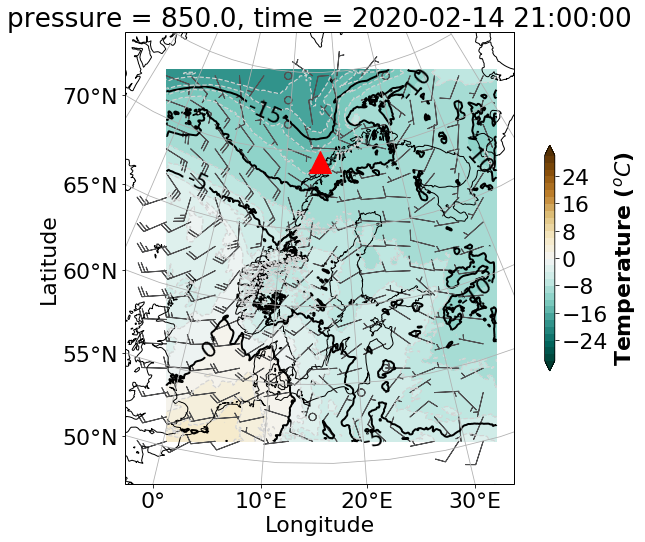

In [20]:
XX, YY = np.meshgrid(fnx.x, fnx.y)
fct.plt_temp_wind_850(fnx, fnx.air_temperature_pl.sel(pressure = 850,).isel(time = forecast_in_hours) - 273.15,
                      fnx.x_wind_pl.sel(pressure = 850,).isel(time = forecast_in_hours),
                      fnx.y_wind_pl.sel(pressure = 850,).isel(time = forecast_in_hours),
                      XX, YY,
                      andenes_x, andenes_y)

if savefig == 1:
    fct.createFolder('%s/850hPa_U_T/%s/' %(figdir,map_area))
    plt.savefig('%s/850hPa_U_T/%s/%s' %(figdir, map_area, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/850hPa_U_T/%s/%s' %(figdir, map_area, fig_name))